<a href="https://colab.research.google.com/github/differential-machine-learning/notebooks/blob/master/DifferentialRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Differential Regression

---
Antoine Savine, April 2020
---


This notebook applies differential learning in the context of classic regression models. It complements to the working paper [Differential Machine Learning](https://sites.google.com/view/differential-machine-learning) by Brian Huge and [Antoine Savine](https://antoinesavine.com) (2020), which explored the new ideas of twin networks and differential training in the context of neural networks. The article also hinted that the methodology applies to arbitrary regression models, including classic linear regression and neural architectures of arbitrary complexity, but did not show other numerical results than with feedforward networks, leaving extensions for additional online material. 

This notebook applies the methodology to polynomial regression in the context of a basket option in a correlated Bachelier model, same as the first numerical example in the article. We will see that, in this context too, differential training offers a  massive performance improvement, compared, not only with standard regression, but also, with ridge (Tikhonov) regularization, even optimized by cross validation. Standard, unregularized regression fails in high dimension. Ridge regression definitely improves performance, but the Tikhonov parameter is found by cross validation, consuming additional data. Differential regression vastly outperforms ridge regression, because it doesn't introduce a bias, as explained in the article, and it works without the need for additional regularization, or hyperparameter optimization.

Textbook regression is often implemented analytically with normal equations, or numerically with gradient descent. In low to medium dimension (1 to less than 10 in practice), the best results are obtained with SVD regression, which stabilises the analytic normal equations by removing insignificant singular values / eigenvalues. All the formulas implemented in the notebook are derived and summarized in [this appendix](https://github.com/differential-machine-learning/appendices/blob/master/App3-Regression.pdf). 

Please execute the code cells in order and **configure your simulations in the cell 'parameters', including Bachelier / basket dimension, polynomial degrees, training sizes, and simulation seed**. Compute and visualize results in the cells below.

Although the notebook implements polynomial regression over Bachelier basket data, it is easy to change the simulation model, financial instrument and regression basis, for example to implement an Asian option in Black and Scholes with a radial basis regression... More complicated, real-world models and instruments cannot be effectively implemented in a notebook, for that we would need a complete financial Derivatives library in C++ or TensorFlow.

For polynomial regression over Bachelier basket data, the performance of various forms of regression varies depending on the Bachelier correlation matrix, which is randomly re-generated on every run, a problem we don't see with neural networks. The performance of ANNs is more consistent and more resilient to changes of model parameters. Although performance is variable with polynomial regression, differential regression consistently outperforms standard and ridge regressions by a vast amount every time.

# Imports

In [4]:
%matplotlib inline

import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import norm
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
import time

# Bachelier pricer/simulator
---
Simulates a training set of basket payoff samples along with pathwise differentials and a test set of ground truth values, deltas and vegas

In [5]:
# helper analytics
def bachPrice(spot, strike, vol, T):
    d = (spot - strike) / vol / np.sqrt(T)
    return  vol * np.sqrt(T) * (d * norm.cdf(d) + norm.pdf(d))

def bachDelta(spot, strike, vol, T):
    d = (spot - strike) / vol / np.sqrt(T)
    return norm.cdf(d)

def bachVega(spot, strike, vol, T):
    d = (spot - strike) / vol / np.sqrt(T)
    return np.sqrt(T) * norm.pdf(d)
#
    
# generates a random correlation matrix
def genCorrel(n):
    randoms = np.random.uniform(low=-1., high=1., size=(2*n, n))
    cov = randoms.T @ randoms
    invvols = np.diag(1. / np.sqrt(np.diagonal(cov)))
    return np.linalg.multi_dot([invvols, cov, invvols])

# main class
class Bachelier:
    
    def __init__(self, 
                 n,
                 T1=1, 
                 T2=2, 
                 K=1.10,
                 volMult=1):
        
        self.n = n
        self.T1 = T1
        self.T2 = T2
        self.K = K
        self.volMult = volMult
                
    # training set: returns S1 (mxn), C2 (mx1) and dC2/dS1 (mxn)
    def trainingSet(self, m, anti=True, seed=None, bktVol=0.2):
    
        np.random.seed(seed)

        # spots all currently 1, without loss of generality
        self.S0 = np.repeat(1., self.n)
        # random correl
        self.corr = genCorrel(self.n)

        # random weights
        self.a = np.random.uniform(low=1., high=10., size=self.n)
        self.a /= np.sum(self.a)
        # random vols
        vols = np.random.uniform(low=5., high = 50., size = self.n)
        # normalize vols for a given volatility of basket, 
        # helps with charts without loss of generality
        avols = (self.a * vols).reshape((-1,1))
        v = np.sqrt(np.linalg.multi_dot([avols.T, self.corr, avols]).reshape(1))
        self.vols = vols * bktVol / v
        self.bktVol = bktVol

        # Choleski etc. for simulation
        diagv = np.diag(self.vols)
        self.cov = np.linalg.multi_dot([diagv, self.corr, diagv])
        self.chol = np.linalg.cholesky(self.cov) * np.sqrt(self.T2 - self.T1)
        # increase vols for simulation of X so we have more samples in the wings
        self.chol0 = self.chol * self.volMult * np.sqrt(self.T1 / (self.T2 - self.T1))
        # simulations
        normals = np.random.normal(size=[2, m, self.n])
        inc0 = normals[0, :, :] @ self.chol0.T
        inc1 = normals[1, :, :] @ self.chol.T
    
        S1 = self.S0 + inc0
        
        S2 = S1 + inc1
        bkt2 = np.dot(S2, self.a)
        pay = np.maximum(0, bkt2 - self.K)

        # two antithetic paths
        if anti:
            
            S2a = S1 - inc1
            bkt2a = np.dot(S2a, self.a)
            paya = np.maximum(0, bkt2a - self.K)
            
            X = S1
            Y = 0.5 * (pay + paya)
    
            # differentials
            Z1 =  np.where(bkt2 > self.K, 1.0, 0.0).reshape((-1,1)) * self.a.reshape((1,-1))
            Z2 =  np.where(bkt2a > self.K, 1.0, 0.0).reshape((-1,1)) * self.a.reshape((1,-1))
            Z = 0.5 * (Z1 + Z2)
                    
        # standard
        else:
        
            X = S1
            Y = pay
            
            # differentials
            Z =  np.where(bkt2 > self.K, 1.0, 0.0).reshape((-1,1)) * self.a.reshape((1,-1))
            
        return X, Y.reshape((-1,1)), Z
    
    # test set: returns an array of independent, uniformly random spots 
    # with corresponding baskets, ground true prices, deltas and vegas
    def testSet(self, lower=0.50, upper=1.50, num=4096, seed=None):
        np.random.seed(seed)
        spots = np.random.uniform(low=lower, high = upper, size=(num, self.n))
        baskets = np.dot(spots, self.a).reshape((-1, 1))
        prices = bachPrice(baskets, self.K, self.bktVol, self.T2 - self.T1)
        deltas = bachDelta(baskets, self.K, self.bktVol, self.T2 - self.T1) \
            @ self.a.reshape((1, -1))
        vegas = bachVega(baskets, self.K, self.bktVol, self.T2 - self.T1) 
        return spots, baskets, prices.reshape((-1, 1)), deltas, vegas


# Polynomial regressor
---
Implements SVD (actually, eigenvalue) based regressions formulas [found here](https://github.com/differential-machine-learning/appendices/blob/master/App3-Regression.pdf) for standard, ridge and differential polynomial regression


In [6]:
class PolyReg:

  # compute all the polynomials we are going to need
  def __init__(self, xTrain, yTrain, dydxTrain, validSize, xTest, yTest, dydxTest, maxDeg):
    
    # store

    self.Y = yTrain
    self.X = xTrain
    self.dYdX = dydxTrain

    self.ty = yTest         
    self.tx = xTest
    self.tdydx = dydxTest   

    # split

    # train set
    self.ay = self.Y[:-validSize, :]
    self.ax = self.X[:-validSize, :]
    self.adydx = self.dYdX[:-validSize, :]

    # valid set
    self.vay = self.Y[-validSize:, :]
    self.vx = self.X[-validSize:, :]
    self.vdydx = self.dYdX[-validSize:, :]

    # monomials

    # generator, without constant
    self.maxDeg = maxDeg
    self.polGen = PolynomialFeatures(degree=maxDeg, include_bias=False)
    
    # train
    self.aphi = self.polGen.fit_transform(self.ax)
    # valid
    self.vaphi = self.polGen.transform(self.vx)
    # test
    self.taphi = self.polGen.transform(self.tx)
    
    # powers, degrees
    self.powers = self.polGen.powers_
    self.degrees = np.sum(self.powers, axis=1)

    # dphi: differentials of monomials to inputs, of shape 
    # (num examples x num monomials x num inputs)
    # train
    self.adphidx = self.aphi[:, :, np.newaxis] \
        * self.powers[np.newaxis, :, :] / (self.ax[:, np.newaxis, :] + 1.0e-08)
    # valid
    self.vadphidx = self.vaphi[:, :, np.newaxis] * \
        self.powers[np.newaxis, :, :] / (self.vx[:, np.newaxis, :] + 1.0e-08)
    # test
    self.tadphidx = self.taphi[:, :, np.newaxis] * \
        self.powers[np.newaxis, :, :] / (self.tx[:, np.newaxis, :] + 1.0e-08)

  # prepare regression of degree p on m examples
  def prepare(self, p, m):
    
    # crop degrees
    self.indices = np.argwhere(self.degrees <= p).reshape(-1)
    
    # crop and center data
    # train phi
    self.x = self.ax[:m, :]
    phi = self.aphi[:m, self.indices]
    self.muphi = phi.mean(axis=0).reshape(1, -1)
    self.phi = phi - self.muphi
    # train y
    y = self.ay[:m, :]
    self.muy = y.mean()
    self.y = y - self.muy
    # train derivs
    self.dydx = self.adydx[:m, :]
    self.dphidx = self.adphidx[:m, self.indices, :]
    
    # valid
    self.vy = self.vay - self.muy
    self.vphi = self.vaphi[:, self.indices] - self.muphi
    self.vdphidx = self.vadphidx[:, self.indices, :]

    # test
    self.tphi = self.taphi[:, self.indices] - self.muphi
    self.tdphidx = self.tadphidx[:, self.indices, :]

    # weight the train derivs for differential cost function
    self.lamj = (y.var() / (self.dydx ** 2).mean(axis=0)).reshape(1, 1, -1)
    self.dphidxw = self.dphidx * np.sqrt(self.lamj)

  # regress
  def regress(self, tikLambda = 0, eigCut = 1.0e-08):
            
      # eigenvalue regression 
      d, p = np.linalg.eigh(self.phi.T @ self.phi)
      
      # cut small eigenvalues
      cut = eigCut * d.mean()
      invD = np.where(d>cut, 1/(d + tikLambda ** 2), 0).reshape(1, -1)
      
      # result, see note
      return ((p * invD) @ p.T @ self.phi.T @ self.y).reshape(-1, 1)    
      
  # find best tikhonov lambda by cross validation
  def ridgeRegress(self, eigCut = 1.0e-08):
    
    # eigenvalue regression 
    d, p = np.linalg.eigh(self.phi.T @ self.phi)
      
    # cut small eigenvalues
    cut = eigCut * d.mean()
    
    # see note
    K = p.T @ self.phi.T @ self.y
    L = p.T @ self.vphi.T @ (self.vy - self.muy)
    M = p.T @ self.vphi.T @ self.vphi @ p
    
    # objective function
    def obj(lam):
        inv_delta = np.where(d>cut, 1/(d + lam ** 2), 0).reshape(1, -1)
        lhs = K.T * inv_delta
        rhs = (M * inv_delta) @ K - 2 * L
        return lhs @ rhs
    
    # optimize
    tikLambda = minimize_scalar(obj, tol=1.0e-02).x
    
    # regress
    return self.regress(tikLambda)    
    
  # differential regress, see memo
  def diffRegress(self, diffLambda = 1, eigCut = 1.0e-08):

    # sums over j of phij.T phij and phijT Zj
    phiTphi = np.tensordot(self.dphidxw, self.dphidx, axes=([0,2],[0,2]))
    phiTz = np.tensordot(self.dphidxw, self.dydx, axes=([0,2],[0,1])).reshape(-1,1)
    
    # eigenvalue regression
    d, p = np.linalg.eigh(self.phi.T @ self.phi + diffLambda * phiTphi)
  
    # cut small eigenvalues
    cut = eigCut * d.mean()
    invD = np.where(d>cut, 1/d, 0).reshape(1, -1)
  
    # eigenvalue regression result
    return ((p * invD) @ p.T @ (self.phi.T @ self.y + diffLambda * phiTz)).reshape(-1, 1)    
              
  # predict values and derivs
  def predictValues(self, beta, phi):
      return phi @ beta + self.muy
  
  def predictDerivs(self, beta, dphidx):
      return np.tensordot(dphidx, beta, (1, 0)).reshape(dphidx.shape[0], -1)

  # results on test set, values
  def testValues(self, beta):
      return self.predictValues(beta, self.tphi)
    
  # results on test set, deltas
  def testDerivs(self, beta):
      return self.predictDerivs(beta, self.tdphidx)

# Testing Functions
---
Perform multiple regressions in many different configurations at once, and show results in charts


In [12]:
def test(dim, maxNtrain, simulSeed, nTest, testSeed, validSize, degs, sizes , deltidx=0):

    # simulation
    print("simulating training, valid and test sets")
    t0 = time.time()
    bach = Bachelier(dim)
    xTrain, yTrain, dydxTrain = bach.trainingSet(maxNtrain, seed=simulSeed)
    xTest, xAxis, yTest, dydxTest, vegas = bach.testSet(num=nTest, seed=testSeed)
    t1 = time.time()
    print("done in %.2f sec" % (t1 - t0))

    # regressor
    print("computing monomials")
    t0 = time.time()    
    regressor = PolyReg(xTrain, yTrain, dydxTrain, validSize, xTest, yTest, dydxTest, max(degs))
    t1 = time.time()
    print("done in %.2f sec" % (t1 - t0))
    
    predvalues = {}    
    preddeltas = {}
    for size in sizes:        
        for deg in degs:
            
            print("config: size %d, degree %d" % (size, deg))
            print("prep regressor")
            t0 = time.time()   
            regressor.prepare(deg, size)
            t1 = time.time()
            print("done in %.2f sec" % (t1 - t0))
                
            print("standard regression")
            t0 = time.time()   
            beta = regressor.regress()
            predictions = regressor.testValues(beta)            
            deltas = regressor.testDerivs(beta)
            predvalues[("standard", size, deg)] = predictions
            preddeltas[("standard", size, deg)] = deltas[:, deltidx]
            t1 = time.time()
            print("done in %.2f sec" % (t1 - t0))
            
            print("differential regression")
            t0 = time.time()   
            beta2 = regressor.diffRegress()
            predictions2 = regressor.testValues(beta2)
            deltas2 = regressor.testDerivs(beta2)
            predvalues[("differential", size, deg)] = predictions2
            preddeltas[("differential", size, deg)] = deltas2[:, deltidx]
            t1 = time.time()
            print("done in %.2f sec" % (t1 - t0))
            
            print("ridge regression by cross validation")
            t0 = time.time()   
            beta3 = regressor.ridgeRegress()
            predictions3 = regressor.testValues(beta3)
            deltas3 = regressor.testDerivs(beta3)
            t1 = time.time()
            print("done in %.2f sec" % (t1 - t0))

            predvalues[("tikhonov", size, deg)] = predictions3
            preddeltas[("tikhonov", size, deg)] = deltas3[:, deltidx]

    return xAxis, yTest, dydxTest[:, deltidx], vegas, predvalues, preddeltas


In [13]:
def graph(title, predictions, xAxis, yAxisName, targets, regType, degs, sizes):
    
    numRows = len(sizes)
    numCols = len(degs)

    fig, ax = plt.subplots(numRows, numCols, squeeze=False)
    fig.set_size_inches(4 * numCols + 1.5, 4 * numRows)

    for i, size in enumerate(sizes):
        ax[i,0].annotate("size %d" % size, xy=(0, 0.5), xytext=(-ax[i,0].yaxis.labelpad-5, 0),
          xycoords=ax[i,0].yaxis.label, textcoords='offset points',
          ha='right', va='center')
  
    for j, deg in enumerate(degs):
        ax[0,j].set_title("degree %d" % deg)
  
    for i, size in enumerate(sizes):        
        for j, deg in enumerate(degs):

            errors = 100 * (predictions[(regType, size, deg)] - targets)
            rmse = np.sqrt((errors ** 2).mean(axis=0))
            t = "rmse %.2f" % rmse
                
            ax[i,j].set_xlabel(t)            
            ax[i,j].set_ylabel(yAxisName)

            ax[i,j].plot(xAxis*100, predictions[(regType, size, deg)]*100, 'co', \
                         markersize=2, markerfacecolor='white', label="predicted")
            ax[i,j].plot(xAxis*100, targets*100, 'r.', markersize=0.5, label='targets')

            ax[i,j].legend(prop={'size': 8}, loc='upper left')

    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    plt.suptitle("% s -- %s in %s regression" % (title, yAxisName, regType), fontsize=16)
    plt.show()

<a id='parameters'></a>
# Parameters
---
Configure your simulations here, including Bachelier / basket dimension, polynomial degrees, training sizes, and simulation seed


In [54]:
# dimension of the basket / Bachelier model 
# -- note maximum regression can handle with reasonable time and RAM is 7 dimension with degree 5
# neural networks do not have such limitations
basketDim = 7

# polynomial degrees and simulation set sizes to perform
degs = [3,5] 
sizes = [1024, 8192, 32768]
validSize=8192 # for tikhonov cross-validation

# set doTikhonov to False to skip cross-validated ridge regression (slow)
doTikhonov = True 
showDeltas = True
deltidx = 0   # which delta to show?

# no not edit
maxNtrain = max(sizes) + (validSize if doTikhonov else 0)

# seed
# simulSeed = 1234
simulSeed = np.random.randint(0, 10000) 
print("using seed %d" % simulSeed)
# testSeed = 4321
testSeed = None

# number of test scenarios
nTest = 4096

using seed 396


# Results

In [ ]:
# performs all requested regressions and collects results

xAxis, yTest, dydxTest, vegas, values, deltas = \
  test(basketDim, maxNtrain, simulSeed, nTest, testSeed, validSize, degs, sizes, deltidx)


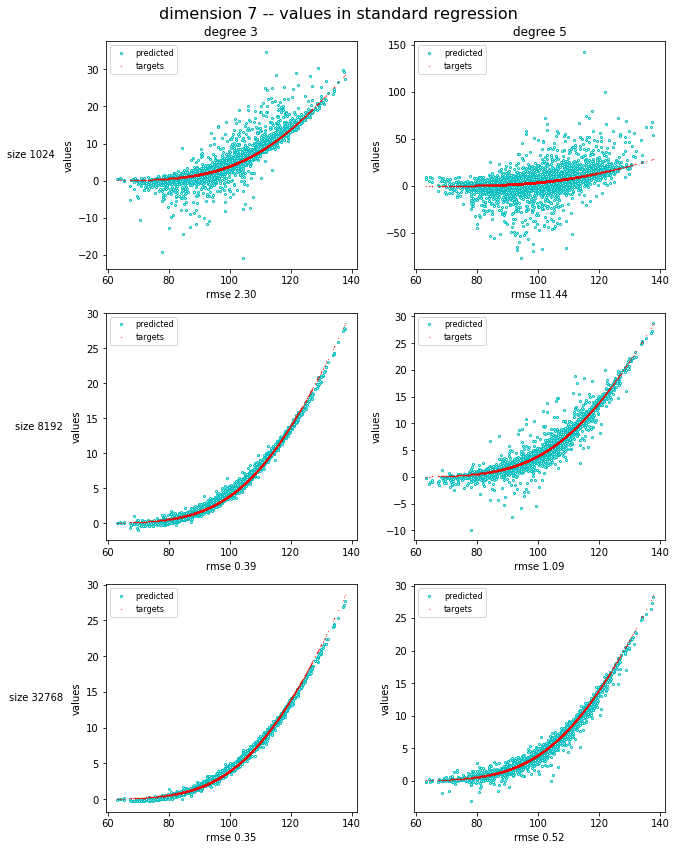

In [56]:
# standard regression value chart
graph("dimension %d" % basketDim, values, xAxis, "values", yTest, "standard", degs, sizes)

Standard regression is known to fail in high dimension, and often produces random looking approximations even with large training sets. This is classically resolved with ridge (Tikhonov) regularization.

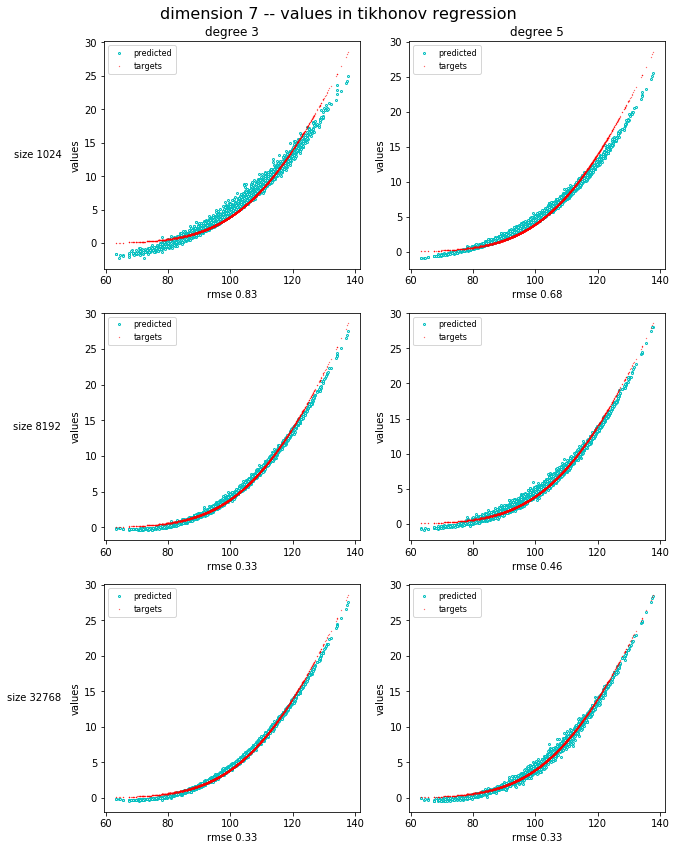

In [57]:
# ridge regression value charts
graph("dimension %d" % basketDim, values, xAxis, "values", yTest, "tikhonov", degs, sizes)

Ridge regularization visibly provides a very significant improvement. In fact, it makes regression viable in medium-high dimension. However, the Tikhonov parameter must be guessed somehow. We optimized it by cross validation, which offers best performance, but at the expense of considerable additional data consumption. Note that ridge regularization also introduces, in return for massive variance reduction, a persistant bias that may not vanish, even with large training sets.

The differential regularization introduced in the article regularizes *without bias*, without the need to guess or search a vital hyperparameter or to generate an additional validation set. It visibly provides an order of magnitude improvement over known alternatives.  

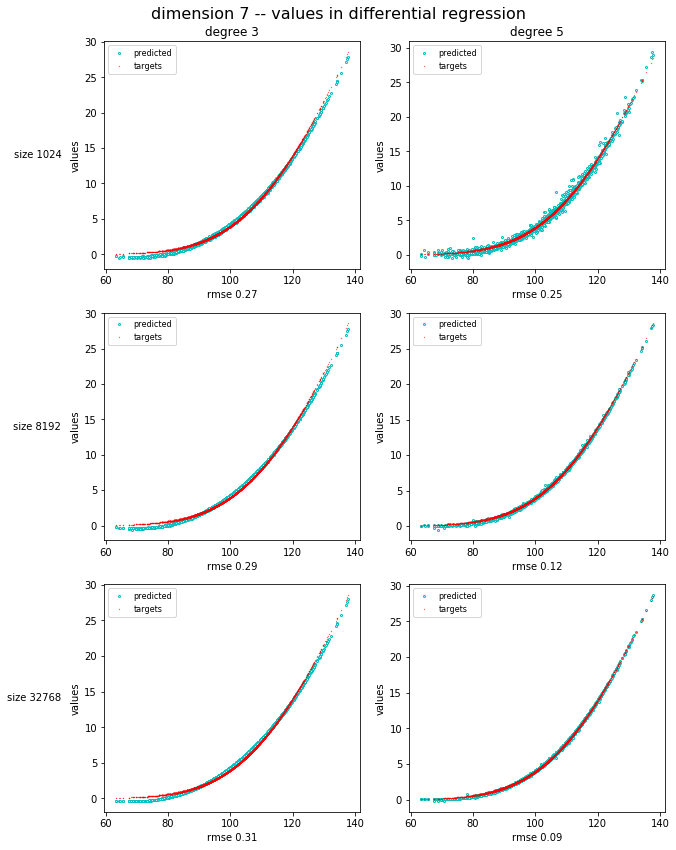

In [58]:
# differential regression value chart
graph("dimension %d" % basketDim, values, xAxis, "values", yTest, "differential", degs, sizes)

Finally, we show deltas produced with the 3 regression methods: standard, ridge and differential, and notice again, that differential regression produces considerably more accurate deltas than alternatives.

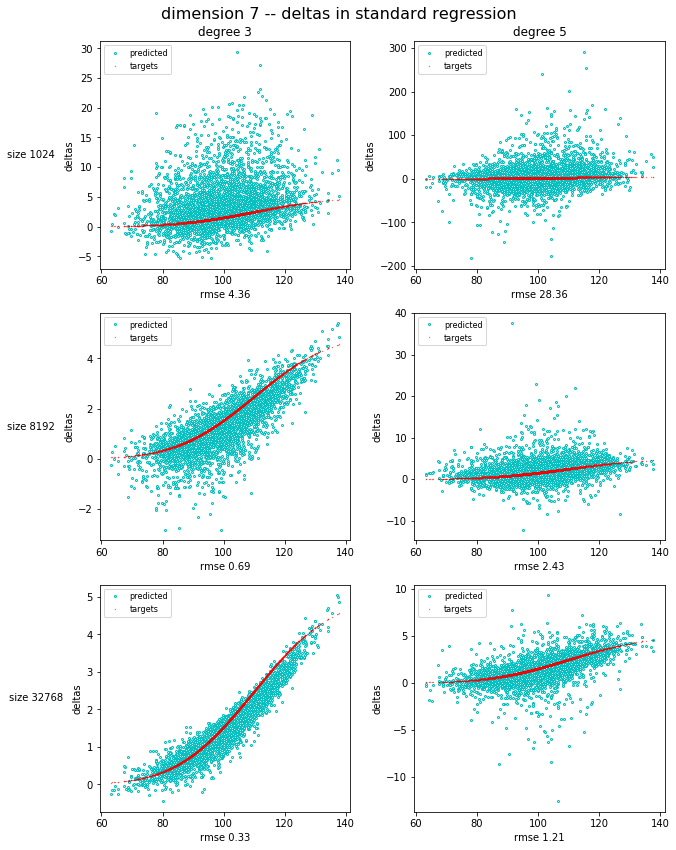

In [59]:
# standard regression delta chart
graph("dimension %d" % basketDim, deltas, xAxis, "deltas", dydxTest, "standard", degs, sizes)

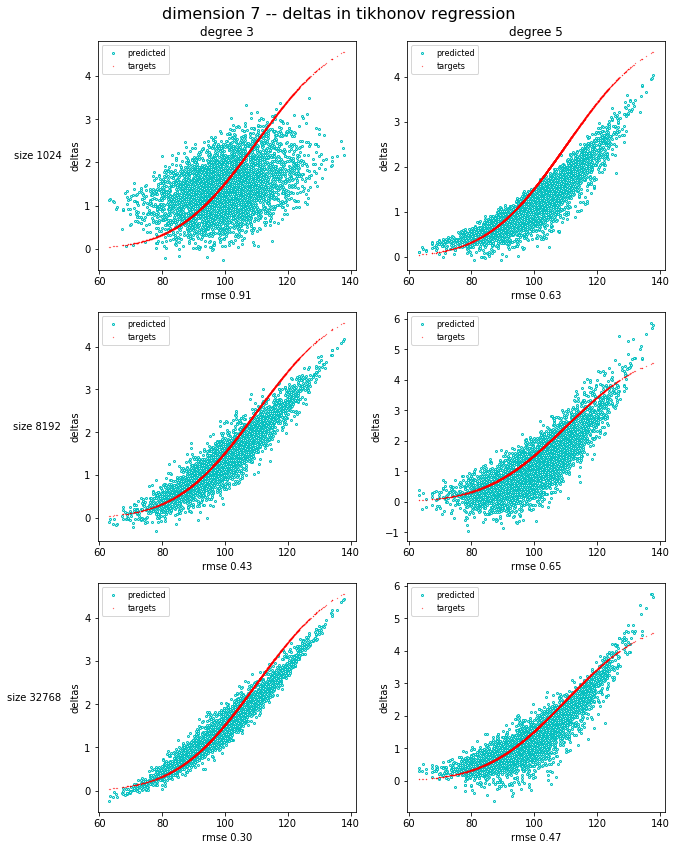

In [60]:
# ridge regression delta chart
graph("dimension %d" % basketDim, deltas, xAxis, "deltas", dydxTest, "tikhonov", degs, sizes)

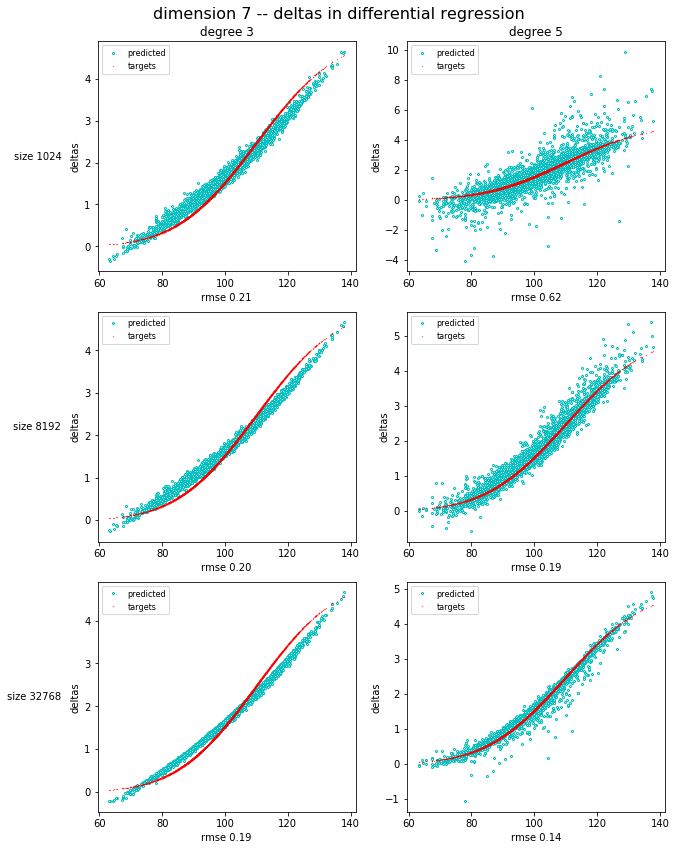

In [61]:
# differential regression delta chart
graph("dimension %d" % basketDim, deltas, xAxis, "deltas", dydxTest, "differential", degs, sizes)